In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from PIL import Image
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

In [21]:
df = pd.read_csv("../image_labels.csv")
df.head()

,Image_Path,Concentration_Level
0,original_patches/patch_0.png,0
1,original_patches/patch_1.png,0
2,original_patches/patch_10.png,1
3,original_patches/patch_11.png,0
4,original_patches/patch_12.png,3


In [22]:
# Define the getter for independent variable
def get_x(row): return '../'+row['Image_Path']

# Define the getter for dependent variable
def get_y(row): return int(row['Concentration_Level'])

# Define how to split the data into train and validation
def splitter(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

    valid_idxs = test.index.tolist()
    train_idxs = train.index.tolist()

    return (train_idxs, valid_idxs)

In [23]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [24]:
classes = df['Concentration_Level'].unique()
num_classes = len(classes)
classes.sort()
classes, num_classes

(array([0, 1, 2, 3]), 4)

In [25]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [26]:
# Define dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = get_x(self.dataframe.iloc[idx])
        image = Image.open(image_path)
        labels = [get_y(self.dataframe.iloc[idx])]

        if self.transform:
            image = self.transform(image)

        # Convert labels to one-hot encoding
        label_vector = [1 if classes[i] in labels else 0 for i in range(num_classes)]

        return image, torch.tensor(label_vector, dtype=torch.float32)

# Define neural network architecture
class MultiClassifierModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassifierModel, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.fc = nn.Linear(1000, num_classes)  # !!!

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

batch_size = 4

# Create the dataset and data loader
dataset = ImageDataset(df, transform=transform)
train_indices, val_indices = splitter(df)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_indices)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_indices)

TypeError: 'Axes' object is not subscriptable

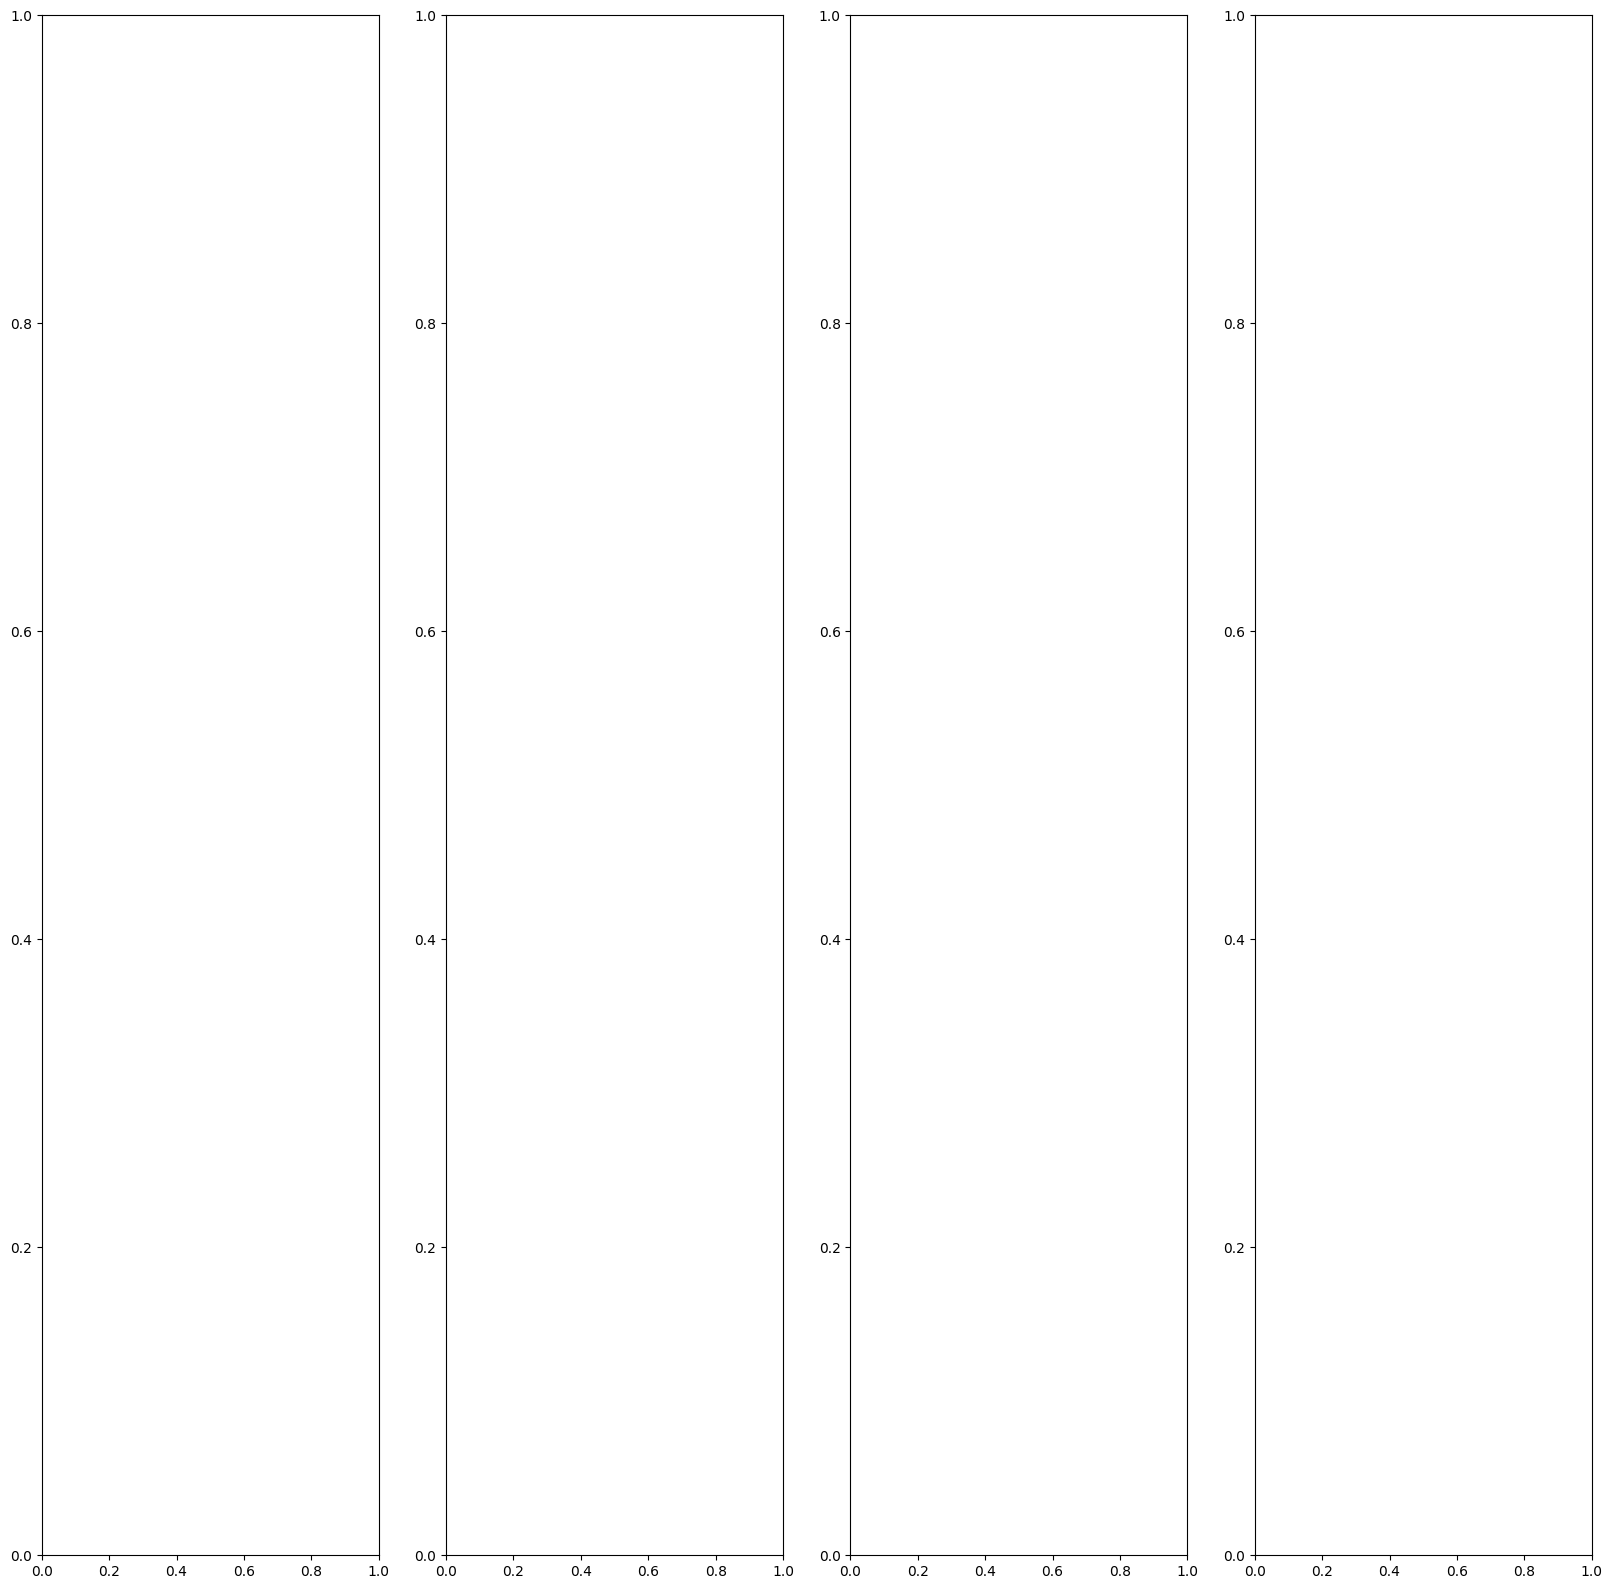

In [27]:
first_batch = next(iter(train_loader))

row = 1
col = 4
fig, ax = plt.subplots(row, col, figsize=(20, 20))

for i in range(row*col):
    matrix = first_batch[0][i].permute(1, 2, 0).numpy()
    scaled_matrix = (((matrix+1) * 255)/2).astype(np.uint8)
    ax[i//col][i%col].imshow(scaled_matrix)
    ax[i//col][i%col].axis('off')
    ax[i//col][i%col].set_title(str([classes[j] for j in range(num_classes) if first_batch[1][i][j] == 1]))

plt.show()

In [28]:
# Training parameters
batch_size = 4
learning_rate =0.0001
num_epochs = 16
print("batch_size: {}, learning_rate: {}, num_epochs: {}".format(batch_size, learning_rate, num_epochs))

# Initialize the model and optimizer
model = MultiClassifierModel(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for multi-label classification

# Create the dataset and data loader
dataset = ImageDataset(df, transform=transform)
train_indices, val_indices = splitter(df)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_indices)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_indices)

batch_size: 4, learning_rate: 0.0001, num_epochs: 16


In [29]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0  # Initialize the loss for this epoch
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()  # Accumulate the loss for this batch
    
    # Calculate the average training loss for this epoch
    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)  # Store the training loss for plotting
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate the average validation loss for this epoch
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)  # Store the validation loss for plotting
    
    print(f'Epoch [{epoch+1}/{num_epochs}] | Val. Loss: {val_loss/len(val_loader):.4f}')


Epoch [1/16] | Val. Loss: 0.0083
Epoch [2/16] | Val. Loss: 0.0073
Epoch [3/16] | Val. Loss: 0.0084
Epoch [4/16] | Val. Loss: 0.0085
Epoch [5/16] | Val. Loss: 0.0105
Epoch [6/16] | Val. Loss: 0.0072
Epoch [7/16] | Val. Loss: 0.0077
Epoch [8/16] | Val. Loss: 0.0065
Epoch [9/16] | Val. Loss: 0.0086
Epoch [10/16] | Val. Loss: 0.0082
Epoch [11/16] | Val. Loss: 0.0105
Epoch [12/16] | Val. Loss: 0.0063
Epoch [13/16] | Val. Loss: 0.0088
Epoch [14/16] | Val. Loss: 0.0138
Epoch [15/16] | Val. Loss: 0.0102
Epoch [16/16] | Val. Loss: 0.0084


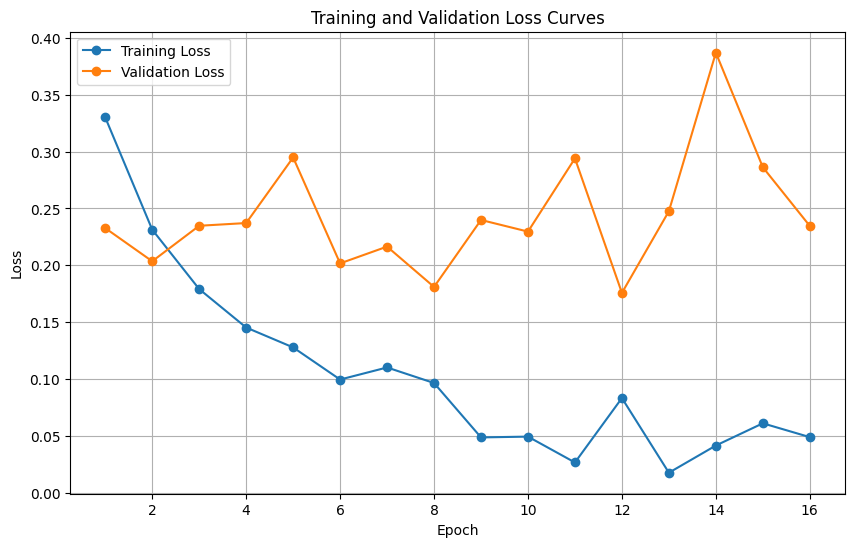

In [30]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

### Saving the trained model

In [31]:
torch.save(model.state_dict(), f'CLS_{str(batch_size)}_{str(learning_rate)}_{str(num_epochs)}.pth')

### Loading the model back

In [33]:
# Load the model
model = MultiClassifierModel(num_classes).to(device)
model.load_state_dict(torch.load('./CLS_4_0.0001_16.pth', map_location=device))

/tmp/ipykernel_3752/4292930663.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./CLS_4_0.0001_16.pth', map_location=device))


<All keys matched successfully>

### Evaluating the model on random samples

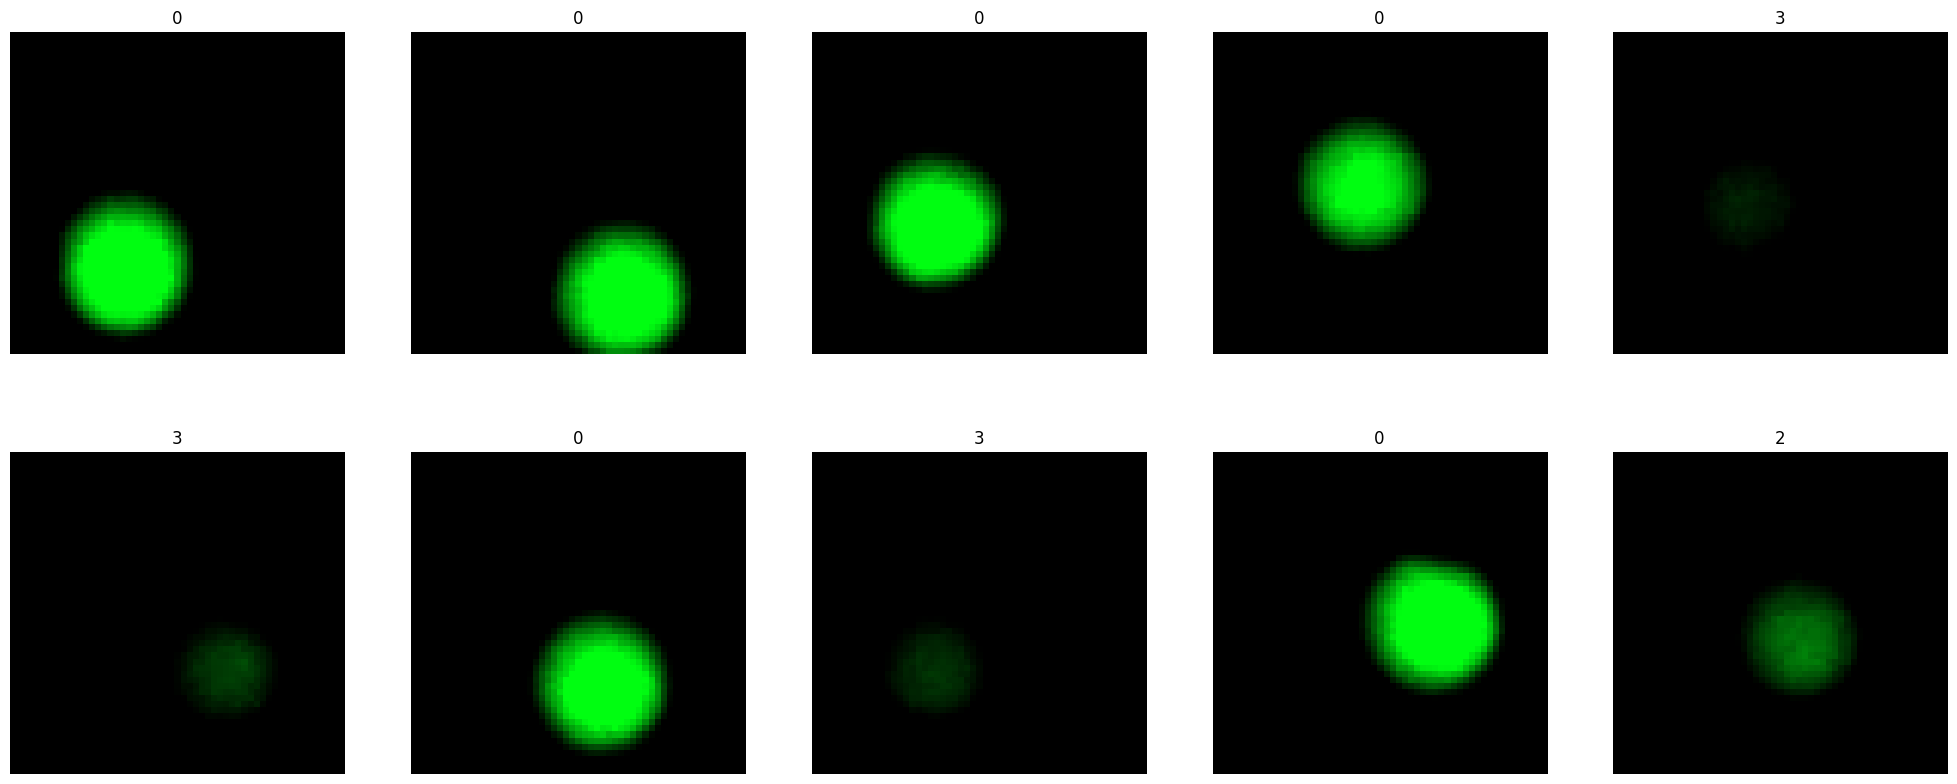

In [42]:
model.eval()  # Set the model to evaluation mode

# Define a function to preprocess the test image
def preprocess_test_image(image):
    image = transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

# Define a function to get predictions from the model
def get_predictions(model, image):
    with torch.no_grad():
        outputs = model(image)
        sigmoid = torch.nn.Sigmoid()
        predictions = sigmoid(outputs)  # Apply sigmoid to get probability scores
    return predictions


row = 2
col = 5
fig, ax = plt.subplots(row, col, figsize=(25, 10))

for i in range(row*col):
    test_image = Image.open(f'../original_patches/{random.choice(os.listdir("../original_patches/"))}').convert('RGB')

    image = preprocess_test_image(test_image).to(device)
    predictions = get_predictions(model, image)[0].argmax()
    
    pred_label = classes[predictions]

    ax[i//col][i%col].imshow(test_image)
    ax[i//col][i%col].axis('off')
    ax[i//col][i%col].set_title(pred_label)

plt.show()